In [1]:
import torch
from torch import nn
from torchvision import transforms # Preprocess jpg images
from PIL import Image
# import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import torchvision # Pre-trained CNN

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda:2'

### Preprocess Flickr8K: Parse captions to lists of ANPs

In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")
def get_ANP(caption, add_empty_adj=False):
    '''Parses a text and returns a list of adj-noun pairs'''
    doc = nlp(caption)
    ANPs = []
    for i,token in enumerate(doc):
        
        # Look for a noun
        if token.pos_ not in ('NOUN'):
            continue

        noun = token.lemma_.lower() # Noun in lemma form
        try:
            # Look for preceding adj
            if doc[i-1].pos_ == 'ADJ':
                adj = doc[i-1].lemma_.lower() # Adj in lemma form
                ANPs.append((adj, noun))
            else:
                if add_empty_adj:
                    ANPs.append(('-', noun))
        except IndexError:
            pass
    return ANPs

get_ANP(u'Three black dogs and a tri-colored dog playing with each other on the road.', add_empty_adj=True)

2022-01-20 13:04:49.302237: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


[('black', 'dog'), ('colored', 'dog'), ('-', 'road')]

In [4]:
from tqdm import tqdm
import pickle

def get_imgs_with_ANPs(fn_caption_file, min_freq=50, keep_empty_adj=False,
                       pickle_fn="saved_fn_anp_dict.pkl"):
    '''Iterate through the img_fn,caption and return img_fn:[(adj,noun)...] '''
    
    # Read previously saved pickle file) => get fn:[ANP...]
    try:
        with open(pickle_fn, "rb") as f:
            print("Reading previously saved dictionary of Filename:Adj-Noun-Pairs...")
            fn_ANP_dict = pickle.load(f)
            
    except FileNotFoundError:
        # Read the txt file => get fn:[ANP...]
        print("Reading captions and looking for Adj-Noun Pairs...")
        with open(fn_caption_file) as f:
            fn_ANP_dict = {}
            lines = [l for l in f]
            for line in tqdm(lines):
                if len(line.split(','))!=2:
                    continue
                fn, cap = line.strip('\n').split(',')
                if fn=='image':
                    continue
                ANPs = get_ANP(cap, add_empty_adj=True)
                if ANPs == []:
                    continue
                fn_ANP_dict[fn] = ANPs
                
        # Save the parsed fn-ANPs dict for future use   
        with open(pickle_fn, "wb") as f:
            pickle.dump(fn_ANP_dict, f)
    
    #===================================================
    #Count the frequency of adjs and nouns
    def count_adj_noun(fn_ANP_dict):
        a_counts, n_counts = {}, {}

        for anp_list in fn_ANP_dict.values():
            for (a,n) in anp_list:
                a_counts[a] = a_counts.get(a,0)+1
                n_counts[n] = n_counts.get(n,0)+1
        return a_counts, n_counts
    
    a_counts, n_counts = count_adj_noun(fn_ANP_dict)  
    if not keep_empty_adj and '-' in a_counts:
        a_counts.pop('-')
    print(f"Before filtering: {len(fn_ANP_dict)} images with ANPs.")
    print(f"{len(a_counts)} adjs, {len(n_counts)} nouns.")
    
    #===================================================
    #Filter adjs and nouns that have appeared minimum N times
    def get_frequent_words(word_count_dict):
        return [w for w,freq in word_count_dict.items() if freq>=min_freq]
    
    print(f"\nAfter filtering: Only keep the adjs or nouns that are annotated in at least {min_freq} images:")
    frequent_adjs = get_frequent_words(a_counts)
    frequent_nouns = get_frequent_words(n_counts)
    ANP_combos = [(a,n) for a in frequent_adjs for n in frequent_nouns]
    print(f"{len(frequent_adjs)} freq adjs X {len(frequent_nouns)} freq nouns = {len(ANP_combos)} possible combinations")
    
    #===================================================
    #Filter images that contain the frequent adjs/nouns
    filtered_fn_ANPs = {}
    for fn, ANPs in fn_ANP_dict.items():
        frequent_ANPs = [(a,n) for a,n in ANPs if a in frequent_adjs and n in frequent_nouns]
        if frequent_ANPs:
            filtered_fn_ANPs[fn]=frequent_ANPs
            
    ANP_set=set()
    for anps in list(filtered_fn_ANPs.values()):
        ANP_set.update(anps)
        
    print(f"{len(filtered_fn_ANPs)} images with {len(ANP_set)} ANPs containing frequent adjs and nouns.")
    
    return frequent_adjs, frequent_nouns, ANP_combos, filtered_fn_ANPs


In [5]:
flickr8k_path = '/scratch/lt2318-h21-resources/03-image-captioning/data/flickr8k/'
flickr8K_caps = flickr8k_path + 'captions.txt'
flickr8K_imgs = flickr8k_path + 'Images/'

adj_classes, noun_classes, ANP_classes, fn_ANPs = get_imgs_with_ANPs(flickr8K_caps, min_freq=50)

Reading previously saved dictionary of Filename:Adj-Noun-Pairs...
Before filtering: 7616 images with ANPs.
654 adjs, 1091 nouns.

After filtering: Only keep the adjs or nouns that are annotated in at least 50 images:
27 freq adjs X 29 freq nouns = 783 possible combinations
4258 images with 254 ANPs containing frequent adjs and nouns.


#### Helper functions to turn raw data into PyTorch tensors

In [6]:
def file_to_tensor(img_path):
    # (PIL.Image obj) => pt tensor 3x224x224
    # load jpg directly as tensor of CxHxW to avoid needing converting from numpy and permuting

    preprocess_fn = transforms.Compose([
        transforms.Resize( 240 ), # img gets cropped if it isn't squared-shaped
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    # PIL Img obj
    with Image.open(img_path) as img:
        img_tensor = preprocess_fn(img)
        return img_tensor

def augment_img_tensors(batch_tensors):
#     tensor_to_PIL = transforms.ToPILImage()
    augment_fn = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
                    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                                            shear=None, interpolation=transforms.InterpolationMode.NEAREST,
                                            fill=(255, 255, 255)),
                    transforms.ToTensor(),
                    ])
    # tensors->PIL objs-> randomly change angles, flip, etc ->new tensors
    new_tensors = [augment_fn(x) for x in batch_tensors]
    new_tensors = torch.stack(new_tensors)
    return new_tensors

def multilabels_to_tensor(list_labels, list_classes):
    '''Returns a tensor of length = num_classes, which is filled with 0 or 1'''
    zeros = torch.zeros(len(list_classes))
    for label in list_labels:
        if label in list_classes:
            idx = list_classes.index(label)
            zeros[idx] = 1
    return zeros

def convert_fn_anp_to_xy(fn_anp, img_path=flickr8K_imgs):
    '''Converst a list of (filename, [labels...]) to 
    a list of (img_tensor, multilabels_tensor) tuples'''
    xy=[] 
    for fn, anp_list in tqdm(fn_anp):
        img = file_to_tensor(img_path+fn)
        anp_labels = multilabels_to_tensor(anp_list, ANP_classes)
        
        adjs, nouns = zip(*anp_list)
        adj_labels = multilabels_to_tensor(adjs, adj_classes)
        noun_labels = multilabels_to_tensor(nouns, noun_classes)
        xy.append((img, anp_labels, adj_labels, noun_labels))
    return xy

#### Train and val datasets: (img: tensor, ANP_labels: tensor, adj_labels: tensor, noun_labels: tensor)

In [7]:
def train_val_split(dataset, val_portion=0.2):
    random.shuffle(dataset)
    val_split = int( len(dataset) * val_portion)
    train, val = dataset[val_split:], dataset[:val_split]
    print(f"Total no of data: {len(dataset)}. Split to train:val = {len(train)}:{len(val)}.")
    return train, val

data = list(fn_ANPs.items())
train_fn_anp, val_fn_anp = train_val_split(data)

Total no of data: 4258. Split to train:val = 3407:851.


In [8]:
trainXY = convert_fn_anp_to_xy(train_fn_anp)
valXY = convert_fn_anp_to_xy(val_fn_anp)

100%|████████████████████████████████████████████████████████████████████████████████| 851/851 [00:06<00:00, 127.46it/s]


### Model that outputs multiple labels:
### ResNet -> fc(num_classes) -> Sigmoid

In [9]:
class ResnetTagger(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        resnet = torchvision.models.resnet101(pretrained=True) # Pretrained ResNet101 model
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.33),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )

        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        out = self.base_model(x)
        return self.sigm(out)
    

In [15]:
class CrossTagger(nn.Module):

    def __init__(self, n_adjs, n_nouns, hiddensize=1024, consider_anp_targets=False):
        super().__init__()
        
        resnet = torchvision.models.resnet101(pretrained=True) # Pretrained ResNet101 model
        
        # This layer is shared for both adj&noun
        resnet.fc = nn.Sequential(
            nn.Linear(in_features=resnet.fc.in_features, out_features=hiddensize), 
        )
        self.base_model = resnet
        
        # Separate FCs for adj/noun
        self.adj_fc = nn.Sequential(
            nn.Dropout(p=0.33),
            nn.Linear(in_features=hiddensize, out_features=n_adjs),
        )
        
        self.noun_fc = nn.Sequential(
            nn.Dropout(p=0.33),
            nn.Linear(in_features=hiddensize, out_features=n_nouns),
        )
        
        self.cross_fc = nn.Sequential(
            nn.Linear(in_features=n_adjs*n_nouns, out_features=hiddensize),
        )

        self.out_fc = nn.Sequential(
#             nn.Dropout(p=0.2),
            nn.Linear(in_features=hiddensize, out_features=n_adjs*n_nouns),
        )
        
        self.sigm = nn.Sigmoid()
        self.consider_anp_targets = consider_anp_targets


    def forward(self, x):
        resnet_out = self.base_model(x) # ---->to be added to the cross-mul 
        # Train to predict adj/noun separately
        adj_reps, noun_reps = self.adj_fc(resnet_out), self.noun_fc(resnet_out)
        adj_out, noun_out = self.sigm(adj_reps), self.sigm(noun_reps)
        
        if self.consider_anp_targets:
            # Multiply the adj/noun reps|sigmoids and go thru another fc layer
#             cross_reps = self.cross_multiply(adj_reps, noun_reps) # AxN reps matrix of size= B, num_adjs*num_nouns 
            cross_reps = self.cross_multiply(adj_out, noun_out) # AxN Sigmoids matrix of size= B, num_adjs*num_nouns 

            cross_reps = self.cross_fc(cross_reps) # BxA*N -> BxHidden
            cross_out = self.out_fc( resnet_out+cross_reps ) # BxHidden + BxHidden: ResNet rep + Cross reps
            cross_out = self.sigm(cross_out) 
        else:
            # Simply multiply the adj/noun sigmoids
            cross_out = self.cross_multiply(adj_out, noun_out)
        
        return cross_out, (adj_out, noun_out)
    
    def cross_multiply(self, t1,t2):
        '''
        Given two tensors of size BxN and BxM, return a tensor of size Bx(N*M),
        where each element in dim1 is i*j for i in N and for j in M
        '''
        # Each element in out-tensor is cross-multiplication of N and M
        out = torch.einsum("di,dj->dij", (t1,t2))
        # Flatten all but the batch dim
        return torch.flatten(out, start_dim=1)

### Train-loop function

In [11]:
from torch.utils.data import DataLoader
from datetime import datetime
from adabound import adabound # installed with `pip3 install adabound`

def chart_losses(epochs, epoch_train_val_losses):
    # ===Draw the line chart===================================
    the_epochs = list(range(1,epochs+1)) # X-axis
    train_losses, val_losses = zip(*epoch_train_val_losses)

    # Lines
    plt.plot(the_epochs, train_losses, label='train loss')
    plt.plot(the_epochs, val_losses, label='val loss')


    plt.title('Losses over iterations')
    plt.xlabel('epoch')
    plt.ylabel('train/val loss')
    plt.legend()
    plt.show()
    
#=============================================================
def train(model, model_name, trainXY, valXY, label_idx,
          device=device, augment_imgs=True,
          batch_size=48, epochs = 10, learning_rate = 1e-4):
    
    model=model.to(device)

    # Grad descend / Loss fn / Dataset iterators
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#     optimizer = adabound.AdaBound(model.parameters(), lr=learning_rate, final_lr=0.1)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # LR adjustment
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = nn.BCELoss()

    train_loader = DataLoader(trainXY, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valXY, batch_size=batch_size, shuffle=False)

    # Epoch (Train+Val) loop

    # Record time lapses and stats in each epoch 
    train_start_time = datetime.now()
    epoch_train_val_losses = []

    for e in range(1,epochs+1):
        start_time = datetime.now()

        #===TRAIN==============================================
        model.train()
        train_loss = 0
        for i, xy in enumerate(train_loader):
            imgs = xy[0]
            if augment_imgs:
                imgs = augment_img_tensors(imgs) #Random augment train imgs
                
            targets = xy[label_idx] # 1,2,3 for anp, adj, noun
            imgs, targets = imgs.to(device), targets.to(device)

            output = model(imgs)

            loss = criterion(output, targets)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Epoch {e} avg train loss {train_loss/(i+1)}", end='\r')
        print()
#         scheduler.step() # Adject LR after an epoch
        
        #===Save model============================================
        torch.save(model, f"trained-models/{model_name}.pt")

        #===VAL/TEST==============================================
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, xy in enumerate(val_loader):
                imgs = xy[0] # No augment
                targets = xy[label_idx]
                imgs, targets = imgs.to(device), targets.to(device)
                output = model(imgs)

                loss = criterion(output, targets)
                val_loss += loss.item()
                print(f"Epoch {e} avg val loss   {val_loss/(i+1)}", end='\r')
        print()

        #===EPOCH INFO and STATS=======================================
        lapsed_time = datetime.now()-start_time
        total_lapsed_time = datetime.now()-train_start_time
        print(f"Epoch {e} train+val time:",str(lapsed_time).split('.')[0], 
              "Total lapsed time:", str(total_lapsed_time).split('.')[0],
             )
        epoch_train_val_losses.append((train_loss, val_loss))

    #Finish all epochs    
    print('DONE!')
    chart_losses(epochs, epoch_train_val_losses)
    
    return model


In [13]:
def train_crossmodel(model, model_name, trainXY, valXY,
          device=device, consider_anp_targets=False, augment_imgs=True, 
          batch_size=40, epochs = 10, learning_rate = 1e-4):
    
    model.consider_anp_targets = consider_anp_targets
    if consider_anp_targets and model.consider_anp_targets:
        print('Consider ANP gold labels when training.')
    
    model=model.to(device)

    # Grad descend / Loss fn / Dataset iterators
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#     optimizer = adabound.AdaBound(model.parameters(), lr=learning_rate, final_lr=learning_rate)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # LR adjustment
    criterion = nn.BCELoss()

    train_loader = DataLoader(trainXY, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valXY, batch_size=batch_size, shuffle=False)

    # Epoch (Train+Val) loop

    # Record time lapses and stats in each epoch 
    train_start_time = datetime.now()
    epoch_train_val_losses = []

    for e in range(1,epochs+1):
        start_time = datetime.now()

        #===TRAIN==============================================
        model.train()
        train_loss = 0
        for i, xy in enumerate(train_loader):
            imgs = xy[0]
            if augment_imgs:
                imgs = augment_img_tensors(imgs) #Random augment train imgs
            adj_targets, noun_targets = xy[2], xy[3] # 1,2,3 for anp, adj, noun
            
            imgs, adj_targets, noun_targets = imgs.to(device), adj_targets.to(device), noun_targets.to(device)

            cross_out, (adj_out, noun_out) = model(imgs)
            
            # The loss is based on learning adjs/nouns separately
            if consider_anp_targets:
                anp_targets = xy[1].to(device)
                loss = criterion(cross_out, anp_targets) + criterion(adj_out, adj_targets) + criterion(noun_out, noun_targets)
            else:
                loss = criterion(adj_out, adj_targets) + criterion(noun_out, noun_targets)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Epoch {e} avg train loss {train_loss/(i+1)}", end='\r')
        print()
#         scheduler.step() # Adject LR after an epoch
        
        #===Save model============================================
        torch.save(model, f"trained-models/{model_name}.pt")

        #===VAL/TEST==============================================
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, xy in enumerate(val_loader):
                imgs = xy[0] # No augment
                adj_targets, noun_targets = xy[2], xy[3] # 1,2,3 for anp, adj, noun
                imgs, adj_targets, noun_targets = imgs.to(device), adj_targets.to(device), noun_targets.to(device)
                cross_out, (adj_out, noun_out) = model(imgs)

                if consider_anp_targets:
                    anp_targets = xy[1].to(device)
                    loss = criterion(cross_out, anp_targets) + criterion(adj_out, adj_targets) + criterion(noun_out, noun_targets)
                else:
                    loss = criterion(adj_out, adj_targets) + criterion(noun_out, noun_targets)
                val_loss += loss.item()
                print(f"Epoch {e} avg val loss   {val_loss/(i+1)}", end='\r')
        print()

        #===EPOCH INFO and STATS=======================================
        lapsed_time = datetime.now()-start_time
        total_lapsed_time = datetime.now()-train_start_time
        print(f"Epoch {e} train+val time:",str(lapsed_time).split('.')[0], 
              "Total lapsed time:", str(total_lapsed_time).split('.')[0],
             )
        epoch_train_val_losses.append((train_loss, val_loss))

    #Finish all epochs    
    print('DONE!')
    chart_losses(epochs, epoch_train_val_losses)
    
    return model

### Initialise new models and train **(Skip this part if already saved trained models)**

/home/gusliahs@GU.GU.SE/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 avg train loss 0.13216378836249886
Epoch 1 avg val loss   0.011459467415180476
Epoch 1 train+val time: 0:00:38 Total lapsed time: 0:00:38
Epoch 2 avg train loss 0.010791789648503485
Epoch 2 avg val loss   0.009262420599245362
Epoch 2 train+val time: 0:00:39 Total lapsed time: 0:01:17
Epoch 3 avg train loss 0.008954916883942107
Epoch 3 avg val loss   0.008301279585187634
Epoch 3 train+val time: 0:00:39 Total lapsed time: 0:01:56
Epoch 4 avg train loss 0.008200483593407651
Epoch 4 avg val loss   0.007816582581856184
Epoch 4 train+val time: 0:00:39 Total lapsed time: 0:02:35
Epoch 5 avg train loss 0.0076846455184506754
Epoch 5 avg val loss   0.0075021073894782226
Epoch 5 train+val time: 0:00:39 Total lapsed time: 0:03:15
Epoch 6 avg train loss 0.0072890198592778675
Epoch 6 avg val loss   0.0074672730018695196
Epoch 6 train+val time: 0:00:38 Total lapsed time: 0:03:54
Epoch 7 avg train loss 0.0069165785705119795
Epoch 7 avg val loss   0.0074081136327650815
Epoch 7 train+val time: 0

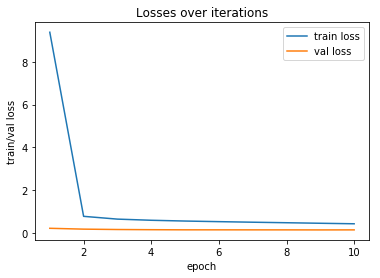

In [13]:
anp_tagger = ResnetTagger(len(ANP_classes))
anp_tagger = train(anp_tagger, "anp-tagger", trainXY, valXY, label_idx=1, augment_imgs=False)

Epoch 1 avg train loss 0.22636176698224644
Epoch 1 avg val loss   0.12745854217145178
Epoch 1 train+val time: 0:00:37 Total lapsed time: 0:00:37
Epoch 2 avg train loss 0.11263160701368896
Epoch 2 avg val loss   0.12787155475881365
Epoch 2 train+val time: 0:00:38 Total lapsed time: 0:01:15
Epoch 3 avg train loss 0.07871657184941667
Epoch 3 avg val loss   0.13652818981144163
Epoch 3 train+val time: 0:00:38 Total lapsed time: 0:01:53
Epoch 4 avg train loss 0.050389039526942754
Epoch 4 avg val loss   0.14286831062701014
Epoch 4 train+val time: 0:00:38 Total lapsed time: 0:02:32
Epoch 5 avg train loss 0.031246666232465026
Epoch 5 avg val loss   0.15005748263663715
Epoch 5 train+val time: 0:00:38 Total lapsed time: 0:03:10
Epoch 6 avg train loss 0.022035469812616497
Epoch 6 avg val loss   0.15312752086255285
Epoch 6 train+val time: 0:00:38 Total lapsed time: 0:03:48
Epoch 7 avg train loss 0.016240724139440228
Epoch 7 avg val loss   0.15650037883056533
Epoch 7 train+val time: 0:00:38 Total la

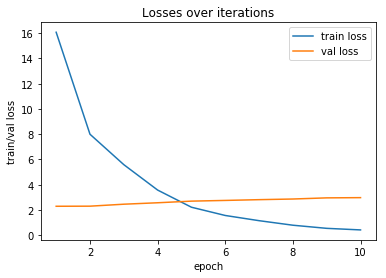

In [17]:
#Train adj multi-label classifier
adj_tagger = ResnetTagger(n_classes=len(adj_classes))
adj_tagger = train(adj_tagger, 'adj-tagger', trainXY=trainXY, valXY=valXY, label_idx=2, augment_imgs=False)

/home/gusliahs@GU.GU.SE/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 avg train loss 0.20217822471135187
Epoch 1 avg val loss   0.10089193615648481
Epoch 1 train+val time: 0:00:38 Total lapsed time: 0:00:38
Epoch 2 avg train loss 0.09173288825951831
Epoch 2 avg val loss   0.10086554537216823
Epoch 2 train+val time: 0:00:37 Total lapsed time: 0:01:15
Epoch 3 avg train loss 0.066668304706543275
Epoch 3 avg val loss   0.09938685968518257
Epoch 3 train+val time: 0:00:37 Total lapsed time: 0:01:53
Epoch 4 avg train loss 0.046416833944303894
Epoch 4 avg val loss   0.10540167532033394
Epoch 4 train+val time: 0:00:38 Total lapsed time: 0:02:31
Epoch 5 avg train loss 0.032974010018605585
Epoch 5 avg val loss   0.10909032366342014
Epoch 5 train+val time: 0:00:38 Total lapsed time: 0:03:10
Epoch 6 avg train loss 0.022202213307921315
Epoch 6 avg val loss   0.11069977324869898
Epoch 6 train+val time: 0:00:38 Total lapsed time: 0:03:49
Epoch 7 avg train loss 0.014800937111738702
Epoch 7 avg val loss   0.11433919726146592
Epoch 7 train+val time: 0:00:38 Total l

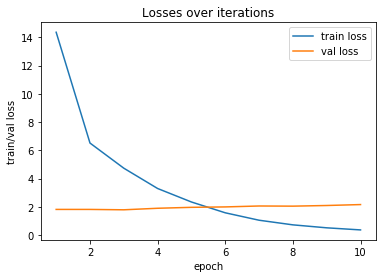

In [14]:
#Train noun multi-label classifier
noun_tagger = ResnetTagger(n_classes=len(noun_classes))
noun_tagger = train(noun_tagger, 'noun-tagger', trainXY=trainXY, valXY=valXY, label_idx=3, augment_imgs=False)

Epoch 1 avg train loss 0.31591483296077943
Epoch 1 avg val loss   0.23500738320527254
Epoch 1 train+val time: 0:00:38 Total lapsed time: 0:00:38
Epoch 2 avg train loss 0.22209491490203642
Epoch 2 avg val loss   0.22935833699173397
Epoch 2 train+val time: 0:00:39 Total lapsed time: 0:01:17
Epoch 3 avg train loss 0.18030380297487028
Epoch 3 avg val loss   0.24310320008684097
Epoch 3 train+val time: 0:00:39 Total lapsed time: 0:01:57
Epoch 4 avg train loss 0.14418827644853958
Epoch 4 avg val loss   0.24696685594541054
Epoch 4 train+val time: 0:00:38 Total lapsed time: 0:02:36
Epoch 5 avg train loss 0.11326684224828382
Epoch 5 avg val loss   0.25543009241422016
Epoch 5 train+val time: 0:00:38 Total lapsed time: 0:03:14
Epoch 6 avg train loss 0.08564500719587382
Epoch 6 avg val loss   0.26571228327574553
Epoch 6 train+val time: 0:00:38 Total lapsed time: 0:03:53
Epoch 7 avg train loss 0.066374620892734174
Epoch 7 avg val loss   0.27620729362523117
Epoch 7 train+val time: 0:00:38 Total lapse

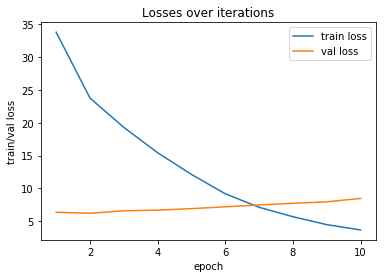

In [117]:
cross_anp_tagger_A = CrossTagger( len(adj_classes), len(noun_classes) )
cross_anp_tagger_A = train_crossmodel( cross_anp_tagger_A, 'cross-anp-tagger-A', trainXY, valXY, augment_imgs=False)

Consider ANP gold labels when training.


/home/gusliahs@GU.GU.SE/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 avg train loss 0.40450500073127973
Epoch 1 avg val loss   0.25805725157260895
Epoch 1 train+val time: 0:00:39 Total lapsed time: 0:00:39
Epoch 2 avg train loss 0.23230985101572302
Epoch 2 avg val loss   0.24410584094849525
Epoch 2 train+val time: 0:00:39 Total lapsed time: 0:01:18
Epoch 3 avg train loss 0.19012035776016323
Epoch 3 avg val loss   0.25609160146939477
Epoch 3 train+val time: 0:00:39 Total lapsed time: 0:01:58
Epoch 4 avg train loss 0.15237361738501592
Epoch 4 avg val loss   0.27115904675288634
Epoch 4 train+val time: 0:00:39 Total lapsed time: 0:02:37
Epoch 5 avg train loss 0.12499672495001978
Epoch 5 avg val loss   0.29408851265907295
Epoch 5 train+val time: 0:00:40 Total lapsed time: 0:03:18
Epoch 6 avg train loss 0.10102539180323135
Epoch 6 avg val loss   0.28845736384391785
Epoch 6 train+val time: 0:00:40 Total lapsed time: 0:03:59
Epoch 7 avg train loss 0.08168510785109775
Epoch 7 avg val loss   0.30288796736435466
Epoch 7 train+val time: 0:00:40 Total lapsed

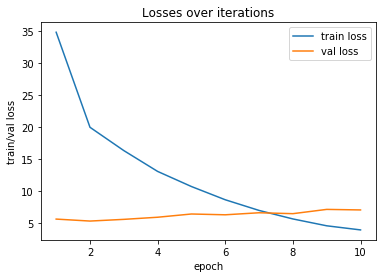

In [14]:
# Residue+ AN-reps-CrossMul
cross_anp_tagger_B = CrossTagger( len(adj_classes), len(noun_classes) )
cross_anp_tagger_B = train_crossmodel(cross_anp_tagger_B, 'cross-anp-tagger-B', trainXY, valXY, augment_imgs=False,
                                      consider_anp_targets=True )

Consider ANP gold labels when training.
Epoch 1 avg train loss 0.44568653664616653
Epoch 1 avg val loss   0.25425351343371655
Epoch 1 train+val time: 0:00:39 Total lapsed time: 0:00:39
Epoch 2 avg train loss 0.23823770828718363
Epoch 2 avg val loss   0.24746541814370595
Epoch 2 train+val time: 0:00:40 Total lapsed time: 0:01:19
Epoch 3 avg train loss 0.19482878890148428
Epoch 3 avg val loss   0.25269407778978356
Epoch 3 train+val time: 0:00:40 Total lapsed time: 0:02:00
Epoch 4 avg train loss 0.15637753375394435
Epoch 4 avg val loss   0.26117486438967963
Epoch 4 train+val time: 0:00:40 Total lapsed time: 0:02:40
Epoch 5 avg train loss 0.12604652622411416
Epoch 5 avg val loss   0.27921556342731824
Epoch 5 train+val time: 0:00:40 Total lapsed time: 0:03:20
Epoch 6 avg train loss 0.10018343218537264
Epoch 6 avg val loss   0.28982755474068935
Epoch 6 train+val time: 0:00:41 Total lapsed time: 0:04:01
Epoch 7 avg train loss 0.07885811339284099
Epoch 7 avg val loss   0.28642625293948433
Epoc

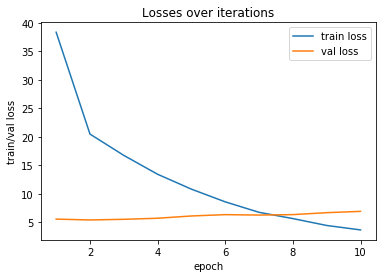

In [16]:
# Residue+ AN-Sigmoids-CrossMul
cross_anp_tagger_C = CrossTagger( len(adj_classes), len(noun_classes) )
cross_anp_tagger_C = train_crossmodel(cross_anp_tagger_C, 'cross-anp-tagger-C', trainXY, valXY, augment_imgs=False,
                                      consider_anp_targets=True )

### Load previously trained-and-saved models

In [19]:
anp_tagger = torch.load('trained-models/anp-tagger.pt')
adj_tagger = torch.load('trained-models/adj-tagger.pt')
noun_tagger = torch.load('trained-models/noun-tagger.pt')

In [20]:
cross_anp_tagger_A = torch.load('trained-models/cross-anp-tagger-A.pt')
cross_anp_tagger_B = torch.load('trained-models/cross-anp-tagger-B.pt')
cross_anp_tagger_C = torch.load('trained-models/cross-anp-tagger-C.pt')

### See how models perform by inputting image and print the predicted labels

In [17]:
def visualise_pred(img_fn, model_classes_dict, dataset=fn_ANPs,
                   img_path=flickr8K_imgs, threshold=0.1):
    '''Use an image as input and compare the original tagging vs the model-predicted tagging'''
    
    #---------------------------------
    if img_fn in dataset:
        gold_labels = dataset[img_fn]
    else:
        gold_labels = None
        
    print(f"Gold labels:", gold_labels)
    #---------------------------------
    
    test_bat = file_to_tensor(img_path+img_fn).unsqueeze(0) # turn to a batchsize=1 tensor
    
    #---------------------------------
    for model, classes in model_classes_dict.items():
        model.eval()
        with torch.no_grad():
            test_bat = test_bat.to(device)
            out = model(test_bat)
            if len(out)>1: # cross_out, (a_out, n_out)
                out = out[0] 

        out=(out>threshold).float()
        predicted_indices = (out[0]==1.0).nonzero(as_tuple=True)[0] # indices of values that are 1
        predicted_labels = [classes[i] for i in predicted_indices]
        
        print(f"Predicted:", predicted_labels)
        print()
        
    #---------------------------------
    with Image.open(img_path+img_fn) as pic:
        plt.axis('off') # hide the axes on the sides
        plt.imshow(pic)
    
    

Gold labels: [('large', 'dog'), ('pink', 'jacket')]
Predicted: [('brown', 'dog')]



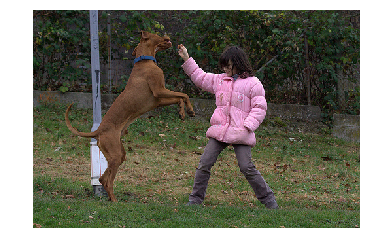

In [21]:
visualise_pred('2229509318_be3fef006b.jpg', {anp_tagger:ANP_classes}, threshold=0.15)

Gold labels: [('large', 'dog'), ('pink', 'jacket')]
Predicted: ['pink', 'large']

Gold labels: [('large', 'dog'), ('pink', 'jacket')]
Predicted: ['dog', 'jacket']



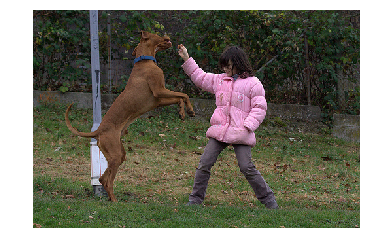

In [22]:
visualise_pred('2229509318_be3fef006b.jpg', {adj_tagger:adj_classes})
visualise_pred('2229509318_be3fef006b.jpg', {noun_tagger:noun_classes})

Gold labels: [('large', 'dog'), ('pink', 'jacket')]
Predicted: [('pink', 'dog'), ('pink', 'jacket'), ('large', 'dog'), ('large', 'jacket')]



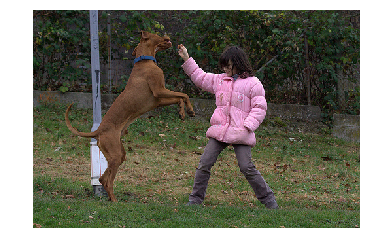

In [23]:
visualise_pred('2229509318_be3fef006b.jpg', {cross_anp_tagger_A:ANP_classes}, threshold=0.2)

Gold labels: [('large', 'dog'), ('pink', 'jacket')]
Predicted: [('brown', 'dog')]

Gold labels: [('large', 'dog'), ('pink', 'jacket')]
Predicted: [('brown', 'dog')]



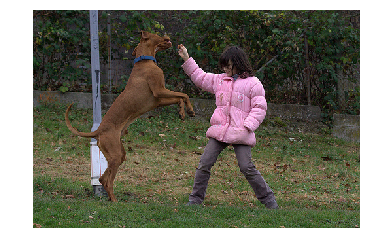

In [25]:
visualise_pred('2229509318_be3fef006b.jpg', {cross_anp_tagger_B:ANP_classes}, threshold=0.05) # res + reps
visualise_pred('2229509318_be3fef006b.jpg', {cross_anp_tagger_C:ANP_classes}, threshold=0.05) # res + sigs

3443326696_fe0549c5be.jpg
Gold labels: [('black', 'uniform')]
Predicted: []



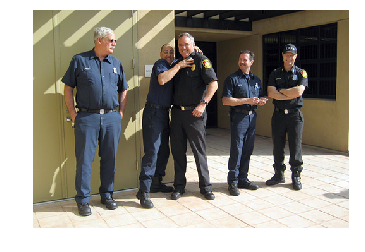

In [26]:
fn, _ = random.choice(val_fn_anp)
# '2229509318_be3fef006b.jpg'
# 3174196837_800689a2f3.jpg
# 241347547_902725b9f8.jpg
print(fn)
visualise_pred(fn, {anp_tagger:ANP_classes})

Gold labels: [('black', 'dog')]
Predicted: [('green', 'grass'), ('white', 'dog'), ('black', 'dog'), ('grassy', 'field')]

Predicted: ['green', 'black', 'grassy']

Predicted: ['dog']

Predicted: [('black', 'dog')]

Predicted: [('black', 'dog')]

Predicted: [('black', 'dog')]



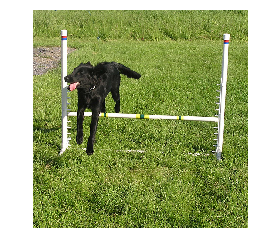

In [27]:
fn, _ = random.choice(val_fn_anp)
models_and_classes = {anp_tagger:ANP_classes,
                      adj_tagger:adj_classes,
                      noun_tagger:noun_classes, 
                      cross_anp_tagger_A:ANP_classes, 
                      cross_anp_tagger_B:ANP_classes, 
                      cross_anp_tagger_C:ANP_classes, 
                     }

visualise_pred(fn, models_and_classes)


Gold labels: None
Predicted: [('little', 'girl'), ('little', 'boy'), ('young', 'man'), ('young', 'child'), ('young', 'boy'), ('young', 'woman'), ('small', 'child'), ('small', 'dog'), ('small', 'boy'), ('red', 'shirt'), ('red', 'jacket'), ('green', 'grass'), ('green', 'shirt'), ('white', 'dog'), ('white', 'shirt'), ('white', 'uniform'), ('blue', 'shirt'), ('black', 'shirt'), ('several', 'people'), ('yellow', 'dog'), ('tan', 'dog'), ('large', 'dog'), ('large', 'rock'), ('snowy', 'mountain'), ('grassy', 'field'), ('old', 'man')]

Predicted: ['little', 'pink', 'young', 'red', 'green', 'white', 'long']

Predicted: ['girl', 'dog', 'kid', 'jacket', 'pant', 'hair']

Predicted: [('pink', 'girl'), ('pink', 'dress'), ('pink', 'hat'), ('pink', 'dog'), ('pink', 'coat'), ('young', 'girl'), ('young', 'dress'), ('orange', 'girl'), ('orange', 'dress'), ('white', 'girl'), ('white', 'dress'), ('purple', 'girl'), ('purple', 'dress'), ('colorful', 'girl'), ('colorful', 'dress'), ('haired', 'girl'), ('haire

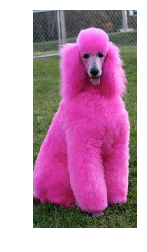

In [40]:
fn = 'pinkdog1.jpg'
visualise_pred(fn, models_and_classes, img_path='', threshold=0.01)

Gold labels: None
Predicted: [('little', 'girl'), ('little', 'boy'), ('young', 'girl'), ('young', 'child'), ('young', 'boy'), ('young', 'woman'), ('small', 'child'), ('small', 'boy'), ('red', 'shirt'), ('white', 'shirt'), ('blue', 'shirt')]

Predicted: ['pink', 'young', 'purple']

Predicted: ['girl', 'dog']

Predicted: [('pink', 'girl'), ('pink', 'hat'), ('pink', 'dog'), ('pink', 'hair'), ('young', 'girl'), ('brown', 'girl'), ('haired', 'girl'), ('long', 'girl')]

Predicted: []

Predicted: [('little', 'girl'), ('pink', 'dress'), ('pink', 'shirt'), ('young', 'girl'), ('small', 'girl'), ('old', 'woman')]



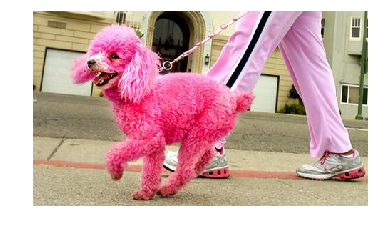

In [38]:
# fn = 'green-dogs.jpg'

fn = 'pinkdog2.jpg'
visualise_pred(fn, models_and_classes, img_path='', threshold=0.02)


In [14]:
# adj_tagger -> A labels
# noun_tagger -> N labels
# generate AxN labels for ANP [1,0,1,...]
# --> use as 